## <font color="green">Hang Gesture Recognition with Deep Learning 

### <font color="brown"> Problem Statement
In this  project, the task is to build a 3D Conv model that will be able to predict the 5 gestures correctly. First import the following libraries to get started. Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

Five gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

   1. **Thumbs Up**: Increase the volume. 
   
   2. **Thumbs Down**: Decrease the volume. 
   
   3. **Left Swipe**: 'Jump' backwards 10 seconds. 
   
   4. **Right Swipe**: 'Jump' forward 10 seconds. 
   
   5. **Stop**: Pause the movie. 

Each video is a sequence of 30 frames (or images).

### <font color="blue"> Objectives for this project:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [60]:
#Checking the GPU configuration

#!nvidia-smi

Wed Nov  8 00:09:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1E:00.0 Off |                  Off |
| 33%   30C    P8    12W / 230W |  15613MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install scipy==1.1.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### <font color="brown">  A random seed was set so that the results won't vary.

In [5]:
np.random.seed(32)
import random as rn
rn.seed(32)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(32)

In [6]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#### In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
# import other needed libraries for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [8]:
project_DataSet='/home/datasets/Project_data'

### Plotting setup

In [9]:
# Used to plot training and validation results with outputs from accuracy and loss

def plot(plot_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[1].plot(plot_history.history['categorical_accuracy'], color='green')   
    axes[1].plot(plot_history.history['val_categorical_accuracy'], color='red')
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

    axes[0].plot(plot_history.history['loss'], color='green')   
    axes[0].plot(plot_history.history['val_loss'], color='red')
    axes[0].legend(['loss','val_loss'])

## <font color="cyran"> Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
class ModelSetUp(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def setup_path(self,project_DataSet):
        self.train_doc = np.random.permutation(open(project_DataSet + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_DataSet + '/' + 'val.csv').readlines())
        self.train_path = project_DataSet + '/' + 'train'
        self.val_path =  project_DataSet + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def setup_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def setup_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.One_Batch_Data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.One_Batch_Data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def One_Batch_Data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def model_training(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        plot_history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return plot_history

        
    @abc.abstractmethod
    def model_setting(self):
        pass

## <font color="red"> Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Built Up a Base Model

In [11]:
class Model_Conv3D1(ModelSetUp):
    
    def model_setting(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser =tf.keras.optimizers.Adam()
        #optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d1=Model_Conv3D1()
conv_3d1.setup_path(project_DataSet)
conv_3d1.setup_image_properties(image_height=160,image_width=160)
conv_3d1.setup_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.model_setting()
conv_3d1_model.summary()

2023-11-08 07:03:20.691661: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-11-08 07:03:20.691722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

#### <font color= "green"> Set Up Cropping

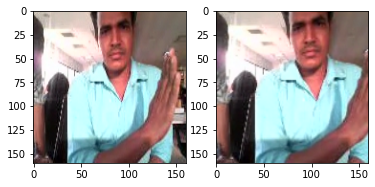

In [13]:
test_generator=Model_Conv3D1()
test_generator.setup_path(project_DataSet)
test_generator.setup_image_properties(image_height=160,image_width=160)
test_generator.setup_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

### <font color="brown"> Let's start experimenting the model build-up with different combinatoins using image resolution, number of frames, and batch_size

In [105]:
conv_3d1.model_training(conv_3d1_model)

67/67 [==============================] - ETA: 0s - loss: 1.5794 - categorical_accuracy: 0.4027
Epoch 00001: val_loss improved from inf to 8.71298, saving model to model_init_2023-11-0801_13_38.356737/model-00001-1.57938-0.40271-8.71298-0.21000.h5
67/67 [==============================] - 98s 1s/step - loss: 1.5794 - categorical_accuracy: 0.4027 - val_loss: 8.7130 - val_categorical_accuracy: 0.2100 - lr: 0.0010


In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### <font color="brown"> The memory limit is with the image resolution of 160x160 using 30 frames and batch_size of 40. The error message will pop up if we hit the limit.

In [15]:
print("Memory limit is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory limit is 3.662109524011612 Gigs


### <font color="brown"> There are trade-offs for choosing the parameters. Below are some experiments running for testing how training time is affected by choosing values of image resolution, number of images in sequence, and batch size

In [ ]:
conv_3d1=Model_Conv3D1()
conv_3d1.setup_path(project_DataSet)
conv_3d1.setup_image_properties(image_height=100,image_width=100)
conv_3d1.setup_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.model_setting()
print("Total num of params:", conv_3d1_model.count_params())
conv_3d1.model_training(conv_3d1_model)

In [117]:
conv_3d1=Model_Conv3D1()
conv_3d1.setup_path(project_DataSet)
conv_3d1.setup_image_properties(image_height=100,image_width=100)
conv_3d1.setup_hyperparams(frames_to_sample=45,batch_size=5,num_epochs=2)
conv_3d1_model=conv_3d1.model_setting()
print("Total num of params:", conv_3d1_model.count_params())
conv_3d1.model_training(conv_3d1_model)

Total Params: 1277637
Epoch 1/2
133/133 [==============================] - ETA: 0s - loss: 1.6667 - categorical_accuracy: 0.3997
Epoch 00001: val_loss improved from inf to 12.05126, saving model to model_init_2023-11-0801_53_19.569230/model-00001-1.66667-0.39970-12.05126-0.16000.h5
133/133 [==============================] - 116s 866ms/step - loss: 1.6667 - categorical_accuracy: 0.3997 - val_loss: 12.0513 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
133/133 [==============================] - ETA: 0s - loss: 1.3474 - categorical_accuracy: 0.4525
Epoch 00002: val_loss improved from 12.05126 to 4.29619, saving model to model_init_2023-11-0801_53_19.569230/model-00002-1.34739-0.45249-4.29619-0.20000.h5
133/133 [==============================] - 113s 854ms/step - loss: 1.3474 - categorical_accuracy: 0.4525 - val_loss: 4.2962 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [111]:
conv_3d1=Model_Conv3D1()
conv_3d1.setup_path(project_DataSet)
conv_3d1.setup_image_properties(image_height=160,image_width=160)
conv_3d1.setup_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.model_setting()
print("Total num of params:", conv_3d1_model.count_params())
conv_3d1.model_training(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5850 - categorical_accuracy: 0.4103
Epoch 00001: val_loss improved from inf to 10.19183, saving model to model_init_2023-11-0801_33_27.230976/model-00001-1.58495-0.41026-10.19183-0.16000.h5
45/45 [==============================] - 97s 2s/step - loss: 1.5850 - categorical_accuracy: 0.4103 - val_loss: 10.1918 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9937 - categorical_accuracy: 0.6395
Epoch 00002: val_loss did not improve from 10.19183
45/45 [==============================] - 96s 2s/step - loss: 0.9937 - categorical_accuracy: 0.6395 - val_loss: 17.4414 - val_categorical_accuracy: 0.1300 - lr: 0.0010


In [115]:
conv_3d1=Model_Conv3D1()
conv_3d1.setup_path(project_DataSet)
conv_3d1.setup_image_properties(image_height=160,image_width=160)
conv_3d1.setup_hyperparams(frames_to_sample=16,batch_size=55,num_epochs=2)
conv_3d1_model=conv_3d1.model_setting()
print("Total num of params:", conv_3d1_model.count_params())
conv_3d1.model_training(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
12/13 [==========================>...] - ETA: 3s - loss: 1.6252 - categorical_accuracy: 0.4258
Epoch 00001: val_loss improved from inf to 1.85566, saving model to model_init_2023-11-0801_44_13.770958/model-00001-1.62476-0.42534-1.85566-0.21000.h5
13/13 [==============================] - 55s 4s/step - loss: 1.6248 - categorical_accuracy: 0.4253 - val_loss: 1.8557 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
12/13 [==========================>...] - ETA: 3s - loss: 0.8187 - categorical_accuracy: 0.6788
Epoch 00002: val_loss did not improve from 1.85566
13/13 [==============================] - 51s 4s/step - loss: 0.8180 - categorical_accuracy: 0.6787 - val_loss: 4.4250 - val_categorical_accuracy: 0.1200 - lr: 0.0010


- ### <font color="brown"> After numerous experiments, the range of **Batch Size** between 5 and 55 are workable. However, the higher values, the higher chance to get overfitting. 
- ### <font color="brown"> The **number of frames** could be set up between 16 to 45. 
- ### <font color="brown"> The **image resolution** could be set up at 100x100, 120x120, or 160x160.
- ### <font color="brown"> The experiment ressults showed that the higher values of **"image resolution"** or **number of frames** in sequence, the more time needed. These two factors have more impactful on the training time than **batch_size**.

## <font color="red"> Model 1 with 3D Conv
### Base Model with Batch Size = 50 and No. of Epochs = 10

In [16]:
class Model_Conv3D1(ModelSetUp):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser =tf.keras.optimizers.Adam()
        #optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d1=Model_Conv3D1()
conv_3d1.setup_path(project_DataSet)
conv_3d1.setup_image_properties(image_height=160,image_width=160)
conv_3d1.setup_hyperparams(frames_to_sample=20,batch_size=50,num_epochs=10)
conv_3d1_model=conv_3d1.model_setting()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [18]:
print("Total num of params:", conv_3d1_model.count_params())
plot_history_model1 = conv_3d1.model_training(conv_3d1_model)

Total num of params: 1117061
Epoch 1/10


2023-11-08 03:02:41.210024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 1.5099 - categorical_accuracy: 0.4133
Epoch 00001: val_loss improved from inf to 1.57081, saving model to model_init_2023-11-0803_02_34.232676/model-00001-1.50992-0.41327-1.57081-0.26000.h5
14/14 [==============================] - 66s 4s/step - loss: 1.5099 - categorical_accuracy: 0.4133 - val_loss: 1.5708 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.0203 - categorical_accuracy: 0.5958
Epoch 00002: val_loss did not improve from 1.57081
14/14 [==============================] - 61s 5s/step - loss: 1.0203 - categorical_accuracy: 0.5958 - val_loss: 1.6719 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.7556 - categorical_accuracy: 0.7104
Epoch 00003: val_loss did not improve from 1.57081
14/14 [==============================] - 59s 4s/step - loss: 0.7556 - categorical_accuracy: 0.7104 - val_lo

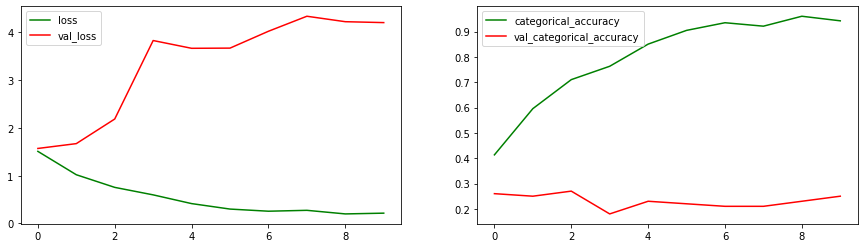

In [20]:
plot(plot_history_model1)

### <font color="brown">  The Model 1 above is obviously overfitting with the validation accuracy of 25% and training accuracy of 94%. more dropout layers will be added to improv the model performance. 

## <font color="red"> Model 2  with 3D Conv
### Added dropout layers=0.5 with Batch_Size = 30 and No. of Epochs = 25

In [21]:
conv_3d2=Model_Conv3D1()
conv_3d2.setup_path(project_DataSet)
conv_3d2.setup_image_properties(image_height=160,image_width=160)
conv_3d2.setup_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=25)
conv_3d2_model=conv_3d2.model_setting(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [22]:
print("Total num of params:", conv_3d2_model.count_params())
plot_history_model2=conv_3d2.model_training(conv_3d2_model,augment_data=True)

Total num of params: 3638981
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.9052 - categorical_accuracy: 0.4035
Epoch 00001: val_loss improved from inf to 3.72190, saving model to model_init_2023-11-0803_18_25.962885/model-00001-1.90517-0.40347-3.72190-0.16000.h5
23/23 [==============================] - 118s 5s/step - loss: 1.9052 - categorical_accuracy: 0.4035 - val_loss: 3.7219 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.3552 - categorical_accuracy: 0.5332
Epoch 00002: val_loss did not improve from 3.72190
23/23 [==============================] - 115s 5s/step - loss: 1.3552 - categorical_accuracy: 0.5332 - val_loss: 5.0671 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.3022 - categorical_accuracy: 0.5445
Epoch 00003: val_loss did not improve from 3.72190
23/23 [==============================] - 115s 5s/step - loss: 1.3

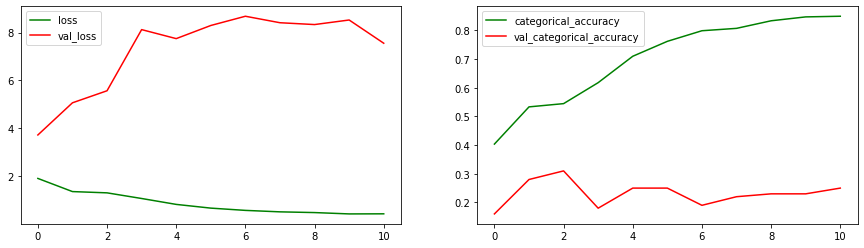

In [25]:
plot(plot_history_model2)

- ### <font color="brown">  The val_loss did not improve much from 3.72. Thus, the model training did not succeed and stopsearly. The model training Epoch stop at the step of 12 /25. Best weights are saved automatically.
- ### <font color="brown">  This is an obvious  overfitting with the validation accuracy of 25% and training accuracy of 85%. Next the filter size and image resolution could be reduced to see if it performs better. Since the loss is oscillating, the learning rate could be set up lower to 0.0002.

## <font color="red"> Model 3 
### Reduced the filter size to (2,2,2) and image res to 120 x  120, frames_to_sample=16, Batch Size = 20, and No. of Epochs = 15

In [38]:
class Model_Conv3D3(ModelSetUp):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
conv_3d3=Model_Conv3D3()
conv_3d3.setup_path(project_DataSet)
conv_3d3.setup_image_properties(image_height=120,image_width=120)
conv_3d3.setup_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d3_model=conv_3d3.model_setting(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_17 (Activation)  (None, 8, 60, 60, 32)    

In [40]:
print("Total num of params:", conv_3d3_model.count_params())
plot_history_model3=conv_3d3.model_training(conv_3d3_model,augment_data=True)

Total num of params: 1762613
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.9768 - categorical_accuracy: 0.3718
Epoch 00001: val_loss improved from inf to 2.10474, saving model to model_init_2023-11-0804_42_56.945260/model-00001-1.97683-0.37179-2.10474-0.21000.h5
34/34 [==============================] - 89s 3s/step - loss: 1.9768 - categorical_accuracy: 0.3718 - val_loss: 2.1047 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.4214 - categorical_accuracy: 0.5226
Epoch 00002: val_loss did not improve from 2.10474
34/34 [==============================] - 87s 3s/step - loss: 1.4214 - categorical_accuracy: 0.5226 - val_loss: 3.4272 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.2227 - categorical_accuracy: 0.5830
Epoch 00003: val_loss did not improve from 2.10474
34/34 [==============================] - 88s 3s/step - loss

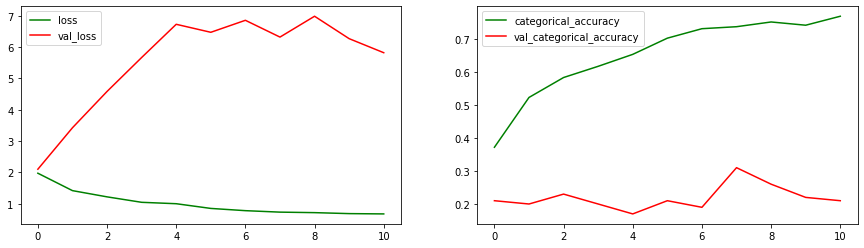

In [41]:
plot(plot_history_model3)

### <font color="brown">  The Model yielded the poor validation accuracy at 21% and training one at 76% , although the parameter size is reduced by half compared to the earlier model. Next more layers will be added.

## <font color="red"> Model 4  
### Added more layers - filtersize=(3,3,3), image res 120x120, frames_to_sample=16, Batch Size = 15, and No. of Epochs = 10

In [42]:
class Model_Conv3D4(ModelSetUp):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv_3d4=Model_Conv3D4()
conv_3d4.setup_path(project_DataSet)
conv_3d4.setup_image_properties(image_height=120,image_width=120)
conv_3d4.setup_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=10)
conv_3d4_model=conv_3d4.model_setting(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_40 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_29 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_29 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [45]:
print("Total num of params:", conv_3d4_model.count_params())
plot_history_model4=conv_3d4.model_training(conv_3d4_model,augment_data=True)

Total num of params: 2556533
Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 2.1563 - categorical_accuracy: 0.3235
Epoch 00001: val_loss improved from inf to 1.81205, saving model to model_init_2023-11-0804_59_38.456219/model-00001-2.15631-0.32353-1.81205-0.18000.h5
45/45 [==============================] - 95s 2s/step - loss: 2.1563 - categorical_accuracy: 0.3235 - val_loss: 1.8120 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.6251 - categorical_accuracy: 0.4434
Epoch 00002: val_loss did not improve from 1.81205
45/45 [==============================] - 89s 2s/step - loss: 1.6251 - categorical_accuracy: 0.4434 - val_loss: 3.2658 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 1.3148 - categorical_accuracy: 0.5452
Epoch 00003: val_loss did not improve from 1.81205
45/45 [==============================] - 89s 2s/step - loss: 1.3148

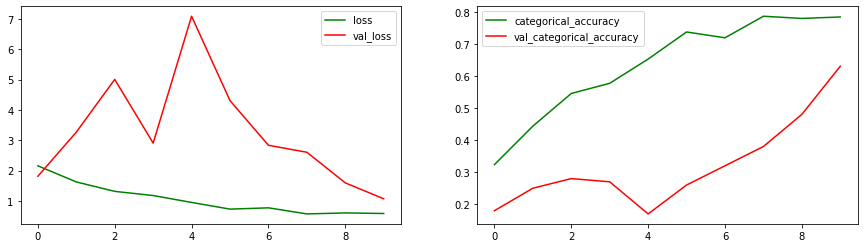

In [46]:
plot(plot_history_model4)

### <font color="brown">  After adding more layers, the performance was improved with much better 63% of validation accuracy and 78% of training one. Dropout layers could be added at the convolutional layers

## <font color="red"> Model 5 
### Added dropouts at convolutional layers, but other parameters stay the same- filtersize=(3,3,3), image res 120x120, frames_to_sample=16, Batch Size = 15, and No. of Epochs = 10.

In [47]:
class Model_Conv3D5(ModelSetUp):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
conv_3d5=Model_Conv3D5()
conv_3d5.setup_path(project_DataSet)
conv_3d5.setup_image_properties(image_height=120,image_width=120)
conv_3d5.setup_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=10)
conv_3d5_model=conv_3d5.model_setting(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_50 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_37 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_37 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_51 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [49]:
print("Total num of params:", conv_3d5_model.count_params())
plot_history_model5=conv_3d5.model_training(conv_3d5_model,augment_data=True)

Total num of params: 2556533
Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 1.8095 - categorical_accuracy: 0.3499
Epoch 00001: val_loss improved from inf to 1.60425, saving model to model_init_2023-11-0805_15_31.641481/model-00001-1.80952-0.34992-1.60425-0.32000.h5
45/45 [==============================] - 97s 2s/step - loss: 1.8095 - categorical_accuracy: 0.3499 - val_loss: 1.6042 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.3381 - categorical_accuracy: 0.5060
Epoch 00002: val_loss did not improve from 1.60425
45/45 [==============================] - 95s 2s/step - loss: 1.3381 - categorical_accuracy: 0.5060 - val_loss: 2.4145 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 1.1362 - categorical_accuracy: 0.5958
Epoch 00003: val_loss did not improve from 1.60425
45/45 [==============================] - 95s 2s/step - loss: 1.1362

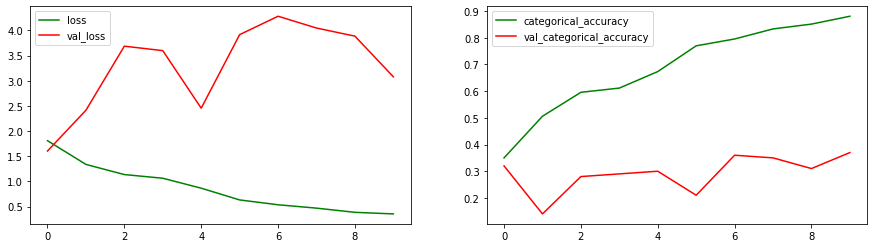

In [50]:
plot(plot_history_model5)

#### <font color="brown">  The overfitting still persists and it doesn't improve after adding dropouts. The validation accuracy reduced to 37% as the training accuracy increased to 88%. More than 1 million parameters are used for all experiments above. It's the time to reduce the model size to seek the performance improvement.

## <font color="red"> Model 6 
### Reduced the number of parameters, but others stay the same- filtersize=(3,3,3), image res 100x100, frames_to_sample=16, Batch Size = 15, and No. of Epochs = 10

In [51]:
class Model_Conv3D6(ModelSetUp):
    
    def model_setting(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
conv_3d6=Model_Conv3D6()
conv_3d6.setup_path(project_DataSet)
conv_3d6.setup_image_properties(image_height=100,image_width=100)
conv_3d6.setup_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=10)
conv_3d6_model=conv_3d6.model_setting(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_60 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_45 (Activation)  (None, 8, 50, 50, 32)    

In [53]:
print("Total num of params:", conv_3d6_model.count_params())
plot_history_model6=conv_3d6.model_training(conv_3d6_model,augment_data=True)

Total num of params: 696645
Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 1.7070 - categorical_accuracy: 0.3786
Epoch 00001: val_loss improved from inf to 2.35550, saving model to model_init_2023-11-0805_36_43.947673/model-00001-1.70704-0.37858-2.35550-0.16000.h5
45/45 [==============================] - 90s 2s/step - loss: 1.7070 - categorical_accuracy: 0.3786 - val_loss: 2.3555 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.1444 - categorical_accuracy: 0.5618
Epoch 00002: val_loss did not improve from 2.35550
45/45 [==============================] - 88s 2s/step - loss: 1.1444 - categorical_accuracy: 0.5618 - val_loss: 3.8710 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.9495 - categorical_accuracy: 0.6161
Epoch 00003: val_loss did not improve from 2.35550
45/45 [==============================] - 88s 2s/step - loss:

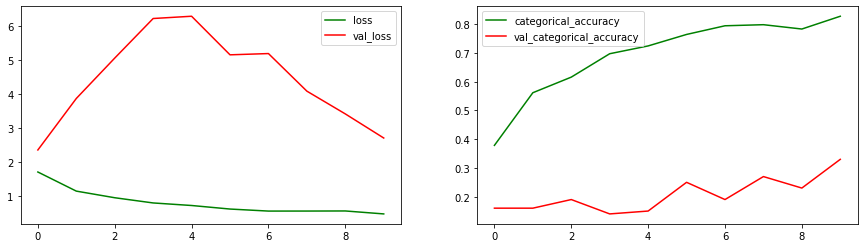

In [54]:
plot(plot_history_model6)

### <font color="brown">  The model performance doesn't improve and get even lower validation accuracy at 33% and training accuracy at 83%. 

## <font color="red"> Model 7
### Reduced the number of parameters again and others stay the same- filtersize=(3,3,3), image res 120x120, frames_to_sample=16, Batch Size = 15, and No. of Epochs = 15

In [55]:
class Model_Conv3D7(ModelSetUp):
    
    def model_setting(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [56]:
conv_3d7=Model_Conv3D7()
conv_3d7.setup_path(project_DataSet)
conv_3d7.setup_image_properties(image_height=120,image_width=120)
conv_3d7.setup_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=15)
conv_3d7_model=conv_3d7.model_setting(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_66 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_49 (Activation)  (None, 8, 60, 60, 32)    

In [57]:
print("Total num of params:", conv_3d7_model.count_params())
plot_history_model7=conv_3d7.model_training(conv_3d7_model,augment_data=True)

Total num of params: 504709
Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.7902 - categorical_accuracy: 0.3341
Epoch 00001: val_loss improved from inf to 2.00986, saving model to model_init_2023-11-0805_51_58.807162/model-00001-1.79017-0.33409-2.00986-0.16000.h5
45/45 [==============================] - 95s 2s/step - loss: 1.7902 - categorical_accuracy: 0.3341 - val_loss: 2.0099 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.3113 - categorical_accuracy: 0.4721
Epoch 00002: val_loss did not improve from 2.00986
45/45 [==============================] - 93s 2s/step - loss: 1.3113 - categorical_accuracy: 0.4721 - val_loss: 2.8100 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 1.0765 - categorical_accuracy: 0.5709
Epoch 00003: val_loss did not improve from 2.00986
45/45 [==============================] - 96s 2s/step - loss:

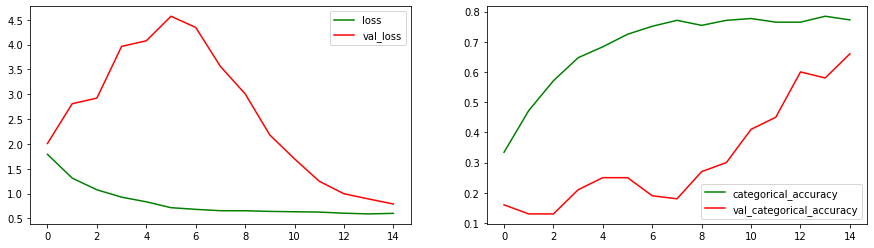

In [58]:
plot(plot_history_model7)

### <font color="brown">  After the number of parameters were reduced, the model performance looked a little better with an increased validation accuracy up to 66% and decreased training accuracy down to 77%. 

## <font color="red"> Model 8 - CNN-LSTM Model

In [67]:
class RNNCNN1(ModelSetUp):
    
    def model_setting(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [68]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.setup_path(project_DataSet)
rnn_cnn1.setup_image_properties(image_height=120,image_width=120)
rnn_cnn1.setup_hyperparams(frames_to_sample=18,batch_size=15,num_epochs=10)
rnn_cnn1_model=rnn_cnn1.model_setting(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 18, 60, 60, 32) 

In [61]:
print("Total num of params:", rnn_cnn1_model.count_params())
plot_history_model8=rnn_cnn1.model_training(rnn_cnn1_model,augment_data=True)

Total num of params: 1657445
Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 1.4375 - categorical_accuracy: 0.3801
Epoch 00001: val_loss improved from inf to 1.81375, saving model to model_init_2023-11-0806_15_17.258872/model-00001-1.43754-0.38009-1.81375-0.23000.h5
45/45 [==============================] - 104s 2s/step - loss: 1.4375 - categorical_accuracy: 0.3801 - val_loss: 1.8137 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.0142 - categorical_accuracy: 0.6244
Epoch 00002: val_loss did not improve from 1.81375
45/45 [==============================] - 98s 2s/step - loss: 1.0142 - categorical_accuracy: 0.6244 - val_loss: 2.4198 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.8770 - categorical_accuracy: 0.6629
Epoch 00003: val_loss did not improve from 1.81375
45/45 [==============================] - 100s 2s/step - loss: 0.87

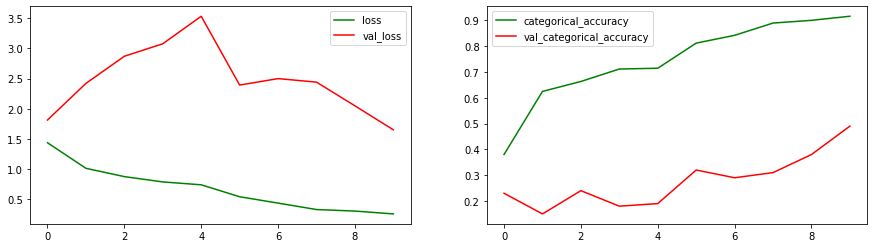

In [62]:
plot(plot_history_model8)

### <font color="brown">  With the new tryout using the CNN-LSTM model, the overfitting issues still existed with better training accuracy at 92%, but having poor validation accuracy at 49%. To address the overfitting issues, the data could be augmented with *slight rotation* applied to the same models again.

### <font color="brown">  

### <font color="Purple"> Set Up data augmentation and check model performance.

In [25]:
class ModelSetUpMoreAugmentation(metaclass= abc.ABCMeta):
    
    def setup_path(self,project_DataSet):
        self.train_doc = np.random.permutation(open(project_DataSet + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_DataSet + '/' + 'val.csv').readlines())
        self.train_path = project_DataSet + '/' + 'train'
        self.val_path =  project_DataSet + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def setup_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def setup_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.One_Batch_Data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.One_Batch_Data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def One_Batch_Data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def model_training(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        plot_history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return plot_history

        
    @abc.abstractmethod
    def model_setting(self):
        pass
    
    

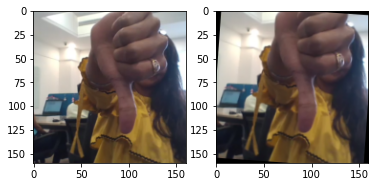

In [26]:
class Test(ModelSetUpMoreAugmentation):
    def model_setting(self):
        pass

test_generator=Test()
test_generator.setup_path(project_DataSet)
test_generator.setup_image_properties(image_height=160,image_width=160)
test_generator.setup_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## <font color="red"> Model 9 with augmentation
### Set up a (3,3,3) kernel/filter with 160x160 Image resolution similar to the previous Model 2

In [27]:
class Model_Conv3D9(ModelSetUpMoreAugmentation):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d9=Model_Conv3D9()
conv_3d9.setup_path(project_DataSet)
conv_3d9.setup_image_properties(image_height=160,image_width=160)
conv_3d9.setup_hyperparams(frames_to_sample=20,batch_size=15,num_epochs=10)
conv_3d9_model=conv_3d9.model_setting(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_22 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_17 (Activation)  (None, 10, 80, 80, 32)   

In [29]:
print("Total num of params:", conv_3d9_model.count_params())
plot_history_model9=conv_3d9.model_training(conv_3d9_model,augment_data=True)

Total num of params: 3638981
Epoch 1/10


2023-11-08 07:08:23.175234: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 2.0430 - categorical_accuracy: 0.3537
Epoch 00001: saving model to model_init_2023-11-0807_08_18.325305/model-00001-2.04302-0.35370-3.47233-0.16000.h5
45/45 [==============================] - 132s 3s/step - loss: 2.0430 - categorical_accuracy: 0.3537 - val_loss: 3.4723 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.3743 - categorical_accuracy: 0.5354
Epoch 00002: saving model to model_init_2023-11-0807_08_18.325305/model-00002-1.37431-0.53544-6.46414-0.16000.h5
45/45 [==============================] - 129s 3s/step - loss: 1.3743 - categorical_accuracy: 0.5354 - val_loss: 6.4641 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 1.1764 - categorical_accuracy: 0.5897
Epoch 00003: saving model to model_init_2023-11-0807_08_18.325305/model-00003-1.17637-0.58974-7.72238-0.15000.h5
45/45 [=====

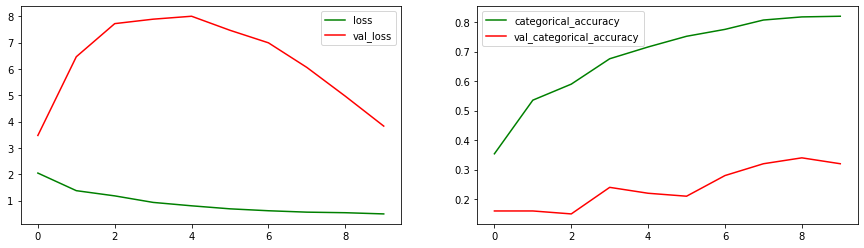

In [30]:
plot(plot_history_model9)

### <font color="brown">  With the new tryout using augmentation strategy, the overfitting issues still existed with both decreasing training accuracy down to 82% and validation one down to 32%. To address the overfitting issues, more experiments using augmentations will be used again.

## <font color="red"> Model 10 with Augmentation
### Set up with a (2,2,2) kernel/filter  and 120x120 Image resolution similar to the previous Model 3

In [31]:
class Model_Conv3D10(ModelSetUpMoreAugmentation):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
conv_3d10=Model_Conv3D10()
conv_3d10.setup_path(project_DataSet)
conv_3d10.setup_image_properties(image_height=120,image_width=120)
conv_3d10.setup_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
conv_3d10_model=conv_3d10.model_setting(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_20 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_28 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_21 (Activation)  (None, 8, 60, 60, 32)    

In [33]:
print("Total num of params:", conv_3d10_model.count_params())
plot_history_model10=conv_3d10.model_training(conv_3d10_model,augment_data=True)

Total num of params: 1762613
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 2.1225 - categorical_accuracy: 0.3250
Epoch 00001: saving model to model_init_2023-11-0807_29_39.888000/model-00001-2.12252-0.32504-1.94988-0.16000.h5
23/23 [==============================] - 84s 4s/step - loss: 2.1225 - categorical_accuracy: 0.3250 - val_loss: 1.9499 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.4089 - categorical_accuracy: 0.5113
Epoch 00002: saving model to model_init_2023-11-0807_29_39.888000/model-00002-1.40885-0.51131-3.21954-0.18000.h5
23/23 [==============================] - 81s 4s/step - loss: 1.4089 - categorical_accuracy: 0.5113 - val_loss: 3.2195 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.2098 - categorical_accuracy: 0.5784
Epoch 00003: saving model to model_init_2023-11-0807_29_39.888000/model-00003-1.20977-0

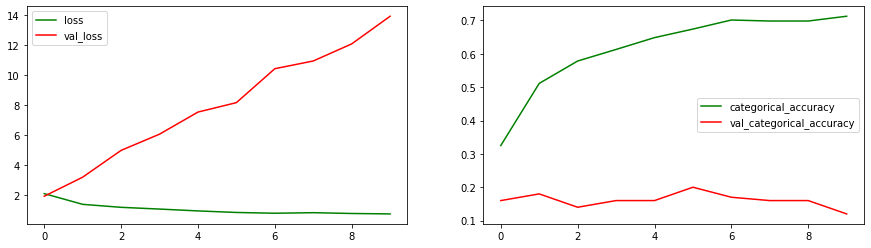

In [34]:
plot(plot_history_model10)

### <font color="brown">  With the same augmentation strategy, the overfitting issues even got worse on both decreasing training accuracy down to 71% and validation one down to 12%. To address the overfitting issues, more experiments using augmentations will be used again.

## <font color="red"> Model 11 with Augmentation
### Added more layers and applied similar rules as did in the previous Model 4

In [35]:
class Model_Conv3D11(ModelSetUpMoreAugmentation):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d11=Model_Conv3D11()
conv_3d11.setup_path(project_DataSet)
conv_3d11.setup_image_properties(image_height=120,image_width=120)
conv_3d11.setup_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
conv_3d11_model=conv_3d11.model_setting(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_34 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_25 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_35 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [37]:
print("Total num of params:", conv_3d11_model.count_params())
plot_history_model11=conv_3d11.model_training(conv_3d11_model,augment_data=True)

Total num of params: 2556533
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 2.3494 - categorical_accuracy: 0.2700
Epoch 00001: saving model to model_init_2023-11-0807_43_13.697871/model-00001-2.34945-0.26998-1.72265-0.16000.h5
23/23 [==============================] - 88s 4s/step - loss: 2.3494 - categorical_accuracy: 0.2700 - val_loss: 1.7226 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.7838 - categorical_accuracy: 0.4057
Epoch 00002: saving model to model_init_2023-11-0807_43_13.697871/model-00002-1.78382-0.40573-2.22439-0.19000.h5
23/23 [==============================] - 83s 4s/step - loss: 1.7838 - categorical_accuracy: 0.4057 - val_loss: 2.2244 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.5477 - categorical_accuracy: 0.4774
Epoch 00003: saving model to model_init_2023-11-0807_43_13.697871/model-00003-1.54770-0

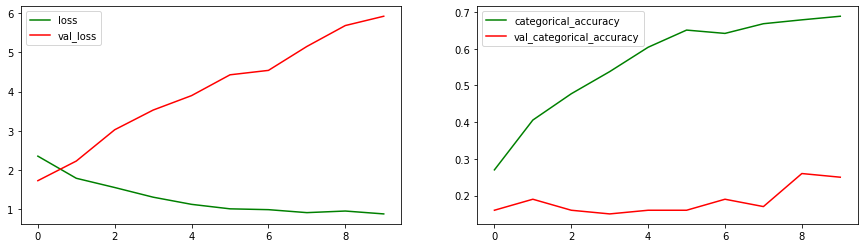

In [38]:
plot(plot_history_model11)

### <font color="brown">  With the same augmentation strategy, the overfitting issues still existed on both decreasing training accuracy down to 68% and validation one at 25%. To address the overfitting issues, more experiments using augmentations will be used again.

## <font color="red"> Model 12 with Augmentation
### Added  more dropouts layers with a similar setup to the previous Model 5

In [39]:
class Model_Conv3D12(ModelSetUpMoreAugmentation):
    
    def model_setting(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [40]:
conv_3d12=Model_Conv3D12()
conv_3d12.setup_path(project_DataSet)
conv_3d12.setup_image_properties(image_height=120,image_width=120)
conv_3d12.setup_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
conv_3d12_model=conv_3d12.model_setting(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_44 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_33 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_33 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_45 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [41]:
print("Total num of params:", conv_3d12_model.count_params())
plot_history_model12=conv_3d12.model_training(conv_3d12_model,augment_data=True)

Total num of params: 2556533
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.9478 - categorical_accuracy: 0.3454
Epoch 00001: saving model to model_init_2023-11-0807_57_00.548331/model-00001-1.94785-0.34540-1.89525-0.21000.h5
23/23 [==============================] - 86s 4s/step - loss: 1.9478 - categorical_accuracy: 0.3454 - val_loss: 1.8953 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.6490 - categorical_accuracy: 0.4314
Epoch 00002: saving model to model_init_2023-11-0807_57_00.548331/model-00002-1.64896-0.43137-2.10509-0.17000.h5
23/23 [==============================] - 86s 4s/step - loss: 1.6490 - categorical_accuracy: 0.4314 - val_loss: 2.1051 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.4909 - categorical_accuracy: 0.4630
Epoch 00003: saving model to model_init_2023-11-0807_57_00.548331/model-00003-1.49087-0

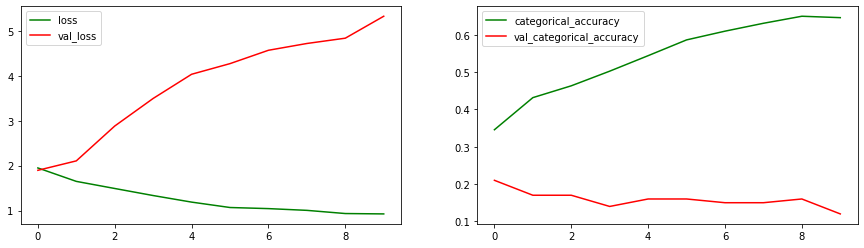

In [42]:
plot(plot_history_model12)

### <font color="blue">  This model suffers much severe overfitting. <font color="brown">  With a dropout rate decreased from 0.5 to 0.25 and the same augmentation strategy, the overfitting issues still existed on both decreasing training accuracy down to 65% and validation one at 12%. To address the overfitting issues, more experiments using augmentations will be used again.

## <font color="red"> Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [43]:
class Model_Conv3D13(ModelSetUpMoreAugmentation):
    
    def model_setting(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv_3d13=Model_Conv3D13()
conv_3d13.setup_path(project_DataSet)
conv_3d13.setup_image_properties(image_height=100,image_width=100)
conv_3d13.setup_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
conv_3d13_model=conv_3d13.model_setting(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_54 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_41 (Activation)  (None, 8, 50, 50, 32)    

In [45]:
print("Total num of params:", conv_3d13_model.count_params())
plot_history_model13=conv_3d13.model_training(conv_3d13_model,augment_data=True)

Total num of params: 696645
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.7997 - categorical_accuracy: 0.3439
Epoch 00001: saving model to model_init_2023-11-0808_11_29.235008/model-00001-1.79974-0.34389-1.72917-0.21000.h5
23/23 [==============================] - 83s 4s/step - loss: 1.7997 - categorical_accuracy: 0.3439 - val_loss: 1.7292 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.2133 - categorical_accuracy: 0.5241
Epoch 00002: saving model to model_init_2023-11-0808_11_29.235008/model-00002-1.21327-0.52413-2.36872-0.18000.h5
23/23 [==============================] - 79s 4s/step - loss: 1.2133 - categorical_accuracy: 0.5241 - val_loss: 2.3687 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/10
22/23 [===========================>..] - ETA: 3s - loss: 0.9342 - categorical_accuracy: 0.6402
Epoch 00003: saving model to model_init_2023-11-0808_11_29.235008/model-00003-0.93450-0.

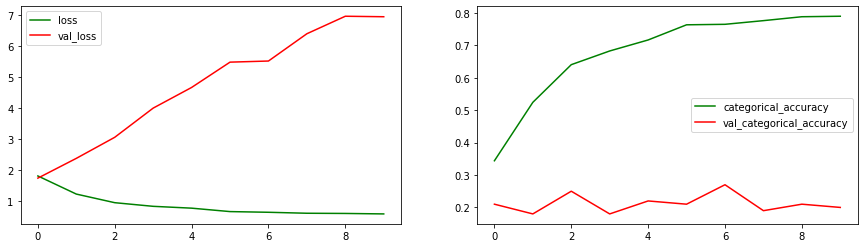

In [46]:
plot(plot_history_model13)

### <font color="blue">  The overfitting issues improved a little bit. <font color="brown">  With the number of dense_neurons reduced from 256 to 128 and the same augmentation strategy, the overfitting issue got much better. It reflected on both increasing training accuracy up to 79% and validation one up to 20%. To address the overfitting issues, more experiments using augmentations will be used again.

## <font color="red"> Model 14 with Augmentation
###  Reduced network parameters again and applied similar rule as the previous Model 7 did.

In [47]:
class Model_Conv3D14(ModelSetUpMoreAugmentation):
    
    def model_setting(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
conv_3d14=Model_Conv3D14()
conv_3d14.setup_path(project_DataSet)
conv_3d14.setup_image_properties(image_height=120,image_width=120)
conv_3d14.setup_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=10)
conv_3d14_model=conv_3d14.model_setting(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_60 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_45 (Activation)  (None, 8, 60, 60, 32)    

In [49]:
print("Total num of params:", conv_3d14_model.count_params())
plot_history_model14=conv_3d14.model_training(conv_3d14_model,augment_data=True)

Total num of params: 504709
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.9760 - categorical_accuracy: 0.3281
Epoch 00001: saving model to model_init_2023-11-0808_25_06.714407/model-00001-1.97604-0.32805-1.69424-0.16000.h5
23/23 [==============================] - 83s 4s/step - loss: 1.9760 - categorical_accuracy: 0.3281 - val_loss: 1.6942 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.3290 - categorical_accuracy: 0.4766
Epoch 00002: saving model to model_init_2023-11-0808_25_06.714407/model-00002-1.32902-0.47662-2.09133-0.14000.h5
23/23 [==============================] - 81s 4s/step - loss: 1.3290 - categorical_accuracy: 0.4766 - val_loss: 2.0913 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.1056 - categorical_accuracy: 0.5679
Epoch 00003: saving model to model_init_2023-11-0808_25_06.714407/model-00003-1.10563-0.

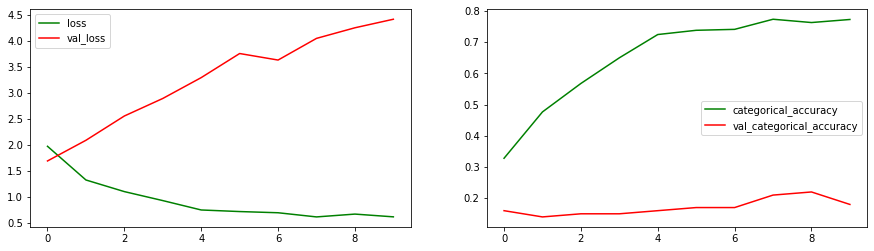

In [50]:
plot(plot_history_model14)

### <font color="blue">  The overfitting issues did not improve. <font color="brown">  With the number of dense_neurons reduced from 128 to 64 and the same augmentation strategy, the overfitting issue still existed. It reflected on both decreasing training accuracy down to 77% and validation one down to 18%. To address the overfitting issues, more experiments using augmentations will be used again.

## <font color="red"> Model 15 with Augmentation
### Used CNN LSTM with GRU with a similar setup to the previous Model 8

In [51]:
class RNNCNN2(ModelSetUpMoreAugmentation):
    
    def model_setting(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.setup_path(project_DataSet)
rnn_cnn2.setup_image_properties(image_height=120,image_width=120)
rnn_cnn2.setup_hyperparams(frames_to_sample=18,batch_size=30,num_epochs=10)
rnn_cnn2_model=rnn_cnn2.model_setting(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32) 

In [53]:
print("Total num of params:", rnn_cnn2_model.count_params())
plot_history_model15=rnn_cnn2.model_training(rnn_cnn2_model,augment_data=True)

Total num of params: 2573925
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.4475 - categorical_accuracy: 0.3982
Epoch 00001: saving model to model_init_2023-11-0808_38_46.051155/model-00001-1.44749-0.39819-1.53942-0.31000.h5
23/23 [==============================] - 95s 4s/step - loss: 1.4475 - categorical_accuracy: 0.3982 - val_loss: 1.5394 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.9753 - categorical_accuracy: 0.6184
Epoch 00002: saving model to model_init_2023-11-0808_38_46.051155/model-00002-0.97527-0.61840-1.68736-0.23000.h5
23/23 [==============================] - 91s 4s/step - loss: 0.9753 - categorical_accuracy: 0.6184 - val_loss: 1.6874 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.7572 - categorical_accuracy: 0.7142
Epoch 00003: saving model to model_init_2023-11-0808_38_46.051155/model-00003-0.75715-0

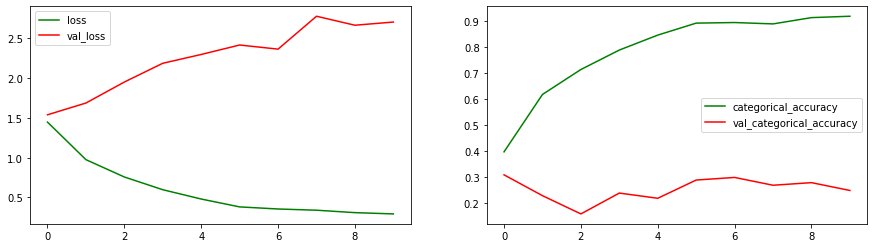

In [54]:
plot(plot_history_model15)

### <font color="brown"> The same overfitting is still dramatical  when the augmentation, dropout, LSTM with GRU were applied, but the number of dense_neurons were added from 64 to 128. <font color="blue">  The overfitting issues did not improve much. <font color="brown">  It reflected on both increasing training accuracy down to 91% and validation one down to 25%. Adding a great number of dense_neurons from 64 to 128 might be the culprit  to cause the overfitting persistence. To address the overfitting issues, more experiments using transfer learning will be used again.

## <font color="red"> Model 16 using Transfer Learning with LSTM

#### <font color = "brown"> Compared to some heavy-duty models like VGG16, Alexnet, and InceptionV3, the MobileNet model was imported and used due to its lightweight architecture with high speed performance.

In [55]:
from keras.applications import mobilenet

In [56]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelSetUpMoreAugmentation):
    
    def model_setting(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 2s 0us/step


In [57]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.setup_path(project_DataSet)
rnn_cnn_tl.setup_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.setup_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=10)
rnn_cnn_tl_model=rnn_cnn_tl.model_setting(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)             

In [58]:
print("Total num of params:", rnn_cnn_tl_model.count_params())
plot_history_model16=rnn_cnn_tl.model_training(rnn_cnn_tl_model,augment_data=True)

Total num of params: 3840453
Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 1.3423 - categorical_accuracy: 0.4170
Epoch 00001: saving model to model_init_2023-11-0808_54_32.021202/model-00001-1.34234-0.41704-0.91741-0.63000.h5
45/45 [==============================] - 91s 2s/step - loss: 1.3423 - categorical_accuracy: 0.4170 - val_loss: 0.9174 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 0.6608 - categorical_accuracy: 0.7541
Epoch 00002: saving model to model_init_2023-11-0808_54_32.021202/model-00002-0.66080-0.75415-0.62336-0.79000.h5
45/45 [==============================] - 89s 2s/step - loss: 0.6608 - categorical_accuracy: 0.7541 - val_loss: 0.6234 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.3838 - categorical_accuracy: 0.8673
Epoch 00003: saving model to model_init_2023-11-0808_54_32.021202/model-00003-0.38383-0.86727-0

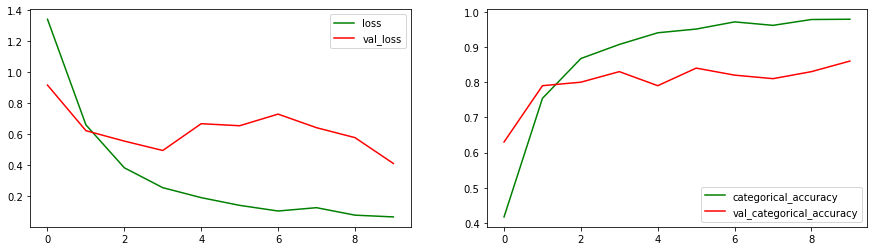

In [59]:
plot(plot_history_model16)

### <font color="brown"> The model performance excelled all others with a high validation accuracy at 86% and an excellent training one at 98%, even the weights using the mobilenet hasn't been well trained yet. More training will be conducted in the next round to check if the model performance will be improved.

## <font color="red"> Model 17 - Transfer Learning with GRU and all weights trained

In [60]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelSetUpMoreAugmentation):
    
    def model_setting(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [61]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.setup_path(project_DataSet)
rnn_cnn_tl2.setup_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.setup_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=10)
rnn_cnn_tl2_model=rnn_cnn_tl2.model_setting(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [62]:
print("Total num of params:", rnn_cnn_tl2_model.count_params())
plot_history_model17=rnn_cnn_tl2.model_training(rnn_cnn_tl2_model,augment_data=True)

Total num of params: 3693253
Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 0.7705 - categorical_accuracy: 0.6931
Epoch 00001: saving model to model_init_2023-11-0809_08_57.608323/model-00001-0.77047-0.69306-1.01807-0.68000.h5
45/45 [==============================] - 89s 2s/step - loss: 0.7705 - categorical_accuracy: 0.6931 - val_loss: 1.0181 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 0.2176 - categorical_accuracy: 0.9351
Epoch 00002: saving model to model_init_2023-11-0809_08_57.608323/model-00002-0.21759-0.93514-0.30165-0.88000.h5
45/45 [==============================] - 86s 2s/step - loss: 0.2176 - categorical_accuracy: 0.9351 - val_loss: 0.3016 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.0899 - categorical_accuracy: 0.9744
Epoch 00003: saving model to model_init_2023-11-0809_08_57.608323/model-00003-0.08990-0.97436-0

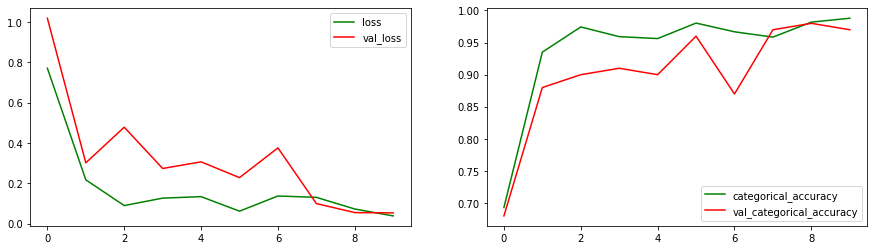

In [63]:
plot(plot_history_model17)

### <font color="brown">  The model performance excelled again with a high validation accuracy at 97% and an excellent training one at 99%.

### <font color="green">  Final Models: <font color="brown">  After all experiments, the Model 17 using transfer learning with GRU along with trained weights performed the best with the outcomes: Training Accuracy : 99%, Validation Accuracy : 97%. 

The best weights with CNN-LSTM saved in this H5 file: model-00010-0.03869-0.98793-0.05370-0.97000.h5 (42 MB).

### <font color="brown"> Model Loading Up and Testing

In [92]:
import time
from keras.models import load_model
model = load_model('model_init_2023-11-0809_08_57.608323/model-00010-0.03869-0.98793-0.05370-0.97000.h5')

In [93]:
test_generator=RNNCNN1()
test_generator.setup_path(project_DataSet)
test_generator.setup_image_properties(image_height=120,image_width=120)
test_generator.setup_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=10)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [94]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [95]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 3 1 0 1 1 1 2 2 3 4 4 4 3 4]
